# CS 229 Project
# Knowledge Distillation Training a Compact Student Model from a Large Teacher
## Authors: Burak Balta & Demetreous Stillman


In [76]:
# Import Libraries
import kagglehub
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

## Load and Preprocess the Data

In [77]:
# Load Quora dataset

df = pd.read_csv("train.csv")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print("Before dropping duplicates:", df.shape)

df.drop_duplicates(subset="question_text", inplace=True)
df.reset_index(drop=True, inplace=True)
class_0 = df[df["target"] == 0].sample(n=50000, random_state=42)
class_1 = df[df["target"] == 1].sample(n=50000, random_state=42)

# Combine and shuffle
df = pd.concat([class_0, class_1])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
#df = df.head(100000)
print("Balanced dataset shape:", df.shape)
print(df["target"].value_counts())
print("After dropping duplicates:", df.shape)

df["target"] = df["target"].astype(int)

df.head()

Before dropping duplicates: (1306122, 3)
Balanced dataset shape: (100000, 3)
target
1    50000
0    50000
Name: count, dtype: int64
After dropping duplicates: (100000, 3)


,qid,question_text,target
0,731308c23db87320d400,"As a man, how does it feel being penetrated by...",1
1,f052b4a4078424107222,"In 200 years, will we only build statues for v...",1
2,5f38763387504c2c52bc,How can women believe in themselves without ne...,0
3,998be6e6f3d413ea3814,Why are Americans so proud of their country wh...,1
4,6145928e2d3fe6038dc2,Why is god such a cunt?,1


## Train Large Teacher Model

In [78]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(df['question_text'], df['target'], test_size=0.2, random_state=42, stratify=df['target'])


In [79]:
# Wraps tokenized inputs and labels for Pytorch
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.lab = torch.tensor(labels.values, dtype=torch.long)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = self.lab[idx]
        return item

    def __len__(self):
        return len(self.lab)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [80]:
# Tokenize

tok_t   = BertTokenizer.from_pretrained("bert-base-uncased")
train_t = tok_t(list(X_train), truncation=True, padding=True, max_length=512)
test_t  = tok_t(list(X_test ), truncation=True, padding=True, max_length=512)

ds_train_t = NewsDataset(train_t, y_train)
ds_test_t  = NewsDataset(test_t , y_test )

train_loader = DataLoader(ds_train_t, batch_size=16, shuffle=True)
test_loader  = DataLoader(ds_test_t , batch_size=16)

In [81]:
teacher = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
).to(device)
num_epochs_teacher = 5
opt_teacher        = torch.optim.AdamW(teacher.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
# Add class weights because of class imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["target"]),
    y=df["target"].values
)
criterion_teacher = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float).to(device)
)

In [83]:
# Teacher Training Loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher.to(device)

# Hyperparameters
learning_rate = 2e-5
num_epochs = 5
optimizer = torch.optim.AdamW(teacher.parameters(), lr=learning_rate)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

train_teacher_accuracy, test_teacher_accuracy, teacher_f1 = [], [], []


for epoch in range(num_epochs):
    teacher.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        targets = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = teacher(**inputs, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    correct = total = 0
    teacher.eval()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            targets = batch['labels'].to(device)
            preds = teacher(**inputs).logits.argmax(1)
            total   += targets.size(0)
            correct += (preds == targets).sum().item()
    train_teacher_accuracy.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    print(f'Train Accuracy: {train_teacher_accuracy[-1]:.2f}%')

    y_true_ep, y_pred_ep = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} Testing"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            targets = batch['labels'].to(device)
            outputs = teacher(**inputs).logits
            preds   = outputs.argmax(1)
            y_true_ep.extend(targets.cpu().numpy())
            y_pred_ep.extend(preds.cpu().numpy())
    acc_ep = accuracy_score(y_true_ep, y_pred_ep) * 100
    f1_ep  = f1_score   (y_true_ep, y_pred_ep)
    test_teacher_accuracy.append(acc_ep)
    teacher_f1.append(f1_ep)
    print(f'Test Accuracy: {acc_ep:.2f}%  F1: {f1_ep:.3f}')

    if epoch == num_epochs - 1:
        y_true_teacher_final = y_true_ep
        y_pred_teacher_final = y_pred_ep

cm_teacher = confusion_matrix(y_true_teacher_final, y_pred_teacher_final, labels=[0, 1])

Epoch 1 Training: 100%|██████████| 5000/5000 [09:04<00:00,  9.18it/s]


Epoch [1/5], Loss: 0.2470
Train Accuracy: 94.83%


Epoch 1 Testing: 100%|██████████| 1250/1250 [01:42<00:00, 12.25it/s]


Test Accuracy: 91.53%  F1: 0.918


Epoch 2 Training: 100%|██████████| 5000/5000 [08:49<00:00,  9.45it/s]


Epoch [2/5], Loss: 0.1592
Train Accuracy: 97.78%


Epoch 2 Testing: 100%|██████████| 1250/1250 [01:38<00:00, 12.68it/s]


Test Accuracy: 91.51%  F1: 0.917


Epoch 3 Training: 100%|██████████| 5000/5000 [08:43<00:00,  9.56it/s]


Epoch [3/5], Loss: 0.0901
Train Accuracy: 99.05%


Epoch 3 Testing: 100%|██████████| 1250/1250 [01:38<00:00, 12.69it/s]


Test Accuracy: 91.33%  F1: 0.915


Epoch 4 Training: 100%|██████████| 5000/5000 [08:42<00:00,  9.56it/s]


Epoch [4/5], Loss: 0.0543
Train Accuracy: 99.60%


Epoch 4 Testing: 100%|██████████| 1250/1250 [01:38<00:00, 12.70it/s]


Test Accuracy: 91.25%  F1: 0.912


Epoch 5 Training: 100%|██████████| 5000/5000 [08:42<00:00,  9.57it/s]


Epoch [5/5], Loss: 0.0369
Train Accuracy: 99.69%


Epoch 5 Testing: 100%|██████████| 1250/1250 [01:38<00:00, 12.72it/s]

Test Accuracy: 91.18%  F1: 0.913


## Train Small Student

In [85]:
# Tokenize input
distil_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings_student = distil_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings_student  = distil_tokenizer(X_test.tolist(),  truncation=True, padding=True, max_length=512)

# Wraps tokenized inputs and labels for Pytorch
train_dataset_student = NewsDataset(train_encodings_student, y_train)
test_dataset_student  = NewsDataset(test_encodings_student,  y_test)

# Load classification model (DistilBERT)
student = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
# Student Training Loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student.to(device)

# Hyperparameters
lr_student = 3e-5
epochs_student = 5
temperature = 4.0 #2.0
alpha = 0.7 #0.5  # distillation vs. CE loss

optim_student = AdamW(student.parameters(), lr=lr_student)
criterion_ce = nn.CrossEntropyLoss(weight=weights)

train_loader_stu = DataLoader(train_dataset_student, batch_size=16, shuffle=True)
test_loader_stu  = DataLoader(test_dataset_student,  batch_size=16)

train_student_accuracy, test_student_accuracy, f1_student = [], [], []

teacher.eval()  # freeze teacher
student.train()

for ep in range(epochs_student):
    student.train()
    for batch in tqdm(train_loader_stu, desc=f"Student Epoch {ep+1} Training"):
        x = {k:v.to(device) for k,v in batch.items() if k != 'labels'}
        y = batch['labels'].to(device)

        optim_student.zero_grad()

        # Teacher output (no grad)
        with torch.no_grad():
            teacher_logits = teacher(**x).logits

        # Student output
        student_outputs = student(**x)
        student_logits = student_outputs.logits

        # Distillation loss (KL divergence on softened probabilities)
        loss_kd = F.kl_div(
            F.log_softmax(student_logits / temperature, dim=1),
            F.softmax(teacher_logits / temperature, dim=1),
            reduction="batchmean"
        ) * (temperature ** 2)

        # Supervised cross-entropy loss
        loss_ce = criterion_ce(student_logits, y)

        # Combine losses
        loss = alpha * loss_kd + (1 - alpha) * loss_ce
        loss.backward()
        optim_student.step()

    # Evaluate on training set
    student.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in train_loader_stu:
            x = {k:v.to(device) for k,v in batch.items() if k != 'labels'}
            y = batch['labels'].to(device)
            preds = student(**x).logits.argmax(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
    train_student_accuracy.append(100 * correct / total)

    # Evaluate on test set
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader_stu, desc=f"Student Epoch {ep+1} Testing"):
            x = {k:v.to(device) for k,v in batch.items() if k != 'labels'}
            y = batch['labels'].to(device)
            preds = student(**x).logits.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred) * 100
    f1  = f1_score(y_true, y_pred)
    test_student_accuracy.append(acc)
    f1_student.append(f1)
    print(f"Epoch {ep+1}: TrainAcc={train_student_accuracy[-1]:.2f}%  TestAcc={acc:.2f}%  F1={f1:.3f}")

cm_student = confusion_matrix(y_true, y_pred, labels=[0,1])


Student Epoch 1 Testing: 100%|██████████| 1250/1250 [00:51<00:00, 24.30it/s]


Epoch 1: TrainAcc=94.29%  TestAcc=90.76%  F1=0.906


Student Epoch 2 Testing: 100%|██████████| 1250/1250 [00:50<00:00, 24.82it/s]


Epoch 2: TrainAcc=97.14%  TestAcc=91.18%  F1=0.913


Student Epoch 3 Testing: 100%|██████████| 1250/1250 [00:51<00:00, 24.21it/s]


Epoch 3: TrainAcc=98.16%  TestAcc=90.74%  F1=0.906


Student Epoch 4 Testing: 100%|██████████| 1250/1250 [00:51<00:00, 24.20it/s]


Epoch 4: TrainAcc=98.59%  TestAcc=90.35%  F1=0.903


Student Epoch 5 Testing: 100%|██████████| 1250/1250 [00:51<00:00, 24.29it/s]

Epoch 5: TrainAcc=98.99%  TestAcc=90.87%  F1=0.910


## Base DistilBert (No Distillation)

In [87]:
# Tokenize input
distil_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = distil_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings  = distil_tokenizer(X_test.tolist(),  truncation=True, padding=True, max_length=512)

# Wraps tokenized inputs and labels for Pytorch
train_dataset = NewsDataset(train_encodings, y_train)
test_dataset  = NewsDataset(test_encodings,  y_test)

# Load classification model (DistilBERT)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
# Base DistilBert Training Loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
learning_rate = 3e-5
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

train_baseDistill_accuracy, test_baseDistill_accuracy, f1_baseDistill = [], [], []

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        targets = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(**inputs, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    correct = total = 0
    model.eval()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            targets = batch['labels'].to(device)
            preds = model(**inputs).logits.argmax(1)
            total   += targets.size(0)
            correct += (preds == targets).sum().item()
    train_baseDistill_accuracy.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    print(f'Train Accuracy: {train_baseDistill_accuracy[-1]:.2f}%')

    y_true_ep, y_pred_ep = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} Testing"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            targets = batch['labels'].to(device)
            outputs = model(**inputs).logits
            preds   = outputs.argmax(1)
            y_true_ep.extend(targets.cpu().numpy())
            y_pred_ep.extend(preds.cpu().numpy())
    acc_ep = accuracy_score(y_true_ep, y_pred_ep) * 100
    f1_ep  = f1_score   (y_true_ep, y_pred_ep)
    test_baseDistill_accuracy.append(acc_ep)
    f1_baseDistill.append(f1_ep)
    print(f'Test Accuracy: {acc_ep:.2f}%  F1: {f1_ep:.3f}')

    if epoch == num_epochs - 1:
        y_true_model_final = y_true_ep
        y_pred_model_final = y_pred_ep

cm_model = confusion_matrix(y_true_model_final, y_pred_model_final, labels=[0, 1])

Epoch 1 Training: 100%|██████████| 5000/5000 [04:35<00:00, 18.13it/s]


Epoch [1/5], Loss: 0.2538
Train Accuracy: 94.82%


Epoch 1 Testing: 100%|██████████| 1250/1250 [00:50<00:00, 24.63it/s]


Test Accuracy: 91.44%  F1: 0.916


Epoch 2 Training: 100%|██████████| 5000/5000 [04:33<00:00, 18.26it/s]


Epoch [2/5], Loss: 0.1621
Train Accuracy: 97.84%


Epoch 2 Testing: 100%|██████████| 1250/1250 [00:51<00:00, 24.39it/s]


Test Accuracy: 91.16%  F1: 0.912


Epoch 3 Training: 100%|██████████| 5000/5000 [04:37<00:00, 18.05it/s]


Epoch [3/5], Loss: 0.0939
Train Accuracy: 99.11%


Epoch 3 Testing: 100%|██████████| 1250/1250 [00:50<00:00, 24.52it/s]


Test Accuracy: 90.77%  F1: 0.907


Epoch 4 Training: 100%|██████████| 5000/5000 [05:00<00:00, 16.61it/s]


Epoch [4/5], Loss: 0.0551
Train Accuracy: 99.37%


Epoch 4 Testing: 100%|██████████| 1250/1250 [00:56<00:00, 22.24it/s]


Test Accuracy: 89.69%  F1: 0.894


Epoch 5 Training: 100%|██████████| 5000/5000 [05:10<00:00, 16.12it/s]


Epoch [5/5], Loss: 0.0372
Train Accuracy: 99.49%


Epoch 5 Testing: 100%|██████████| 1250/1250 [00:58<00:00, 21.50it/s]

Test Accuracy: 89.61%  F1: 0.893


## Results

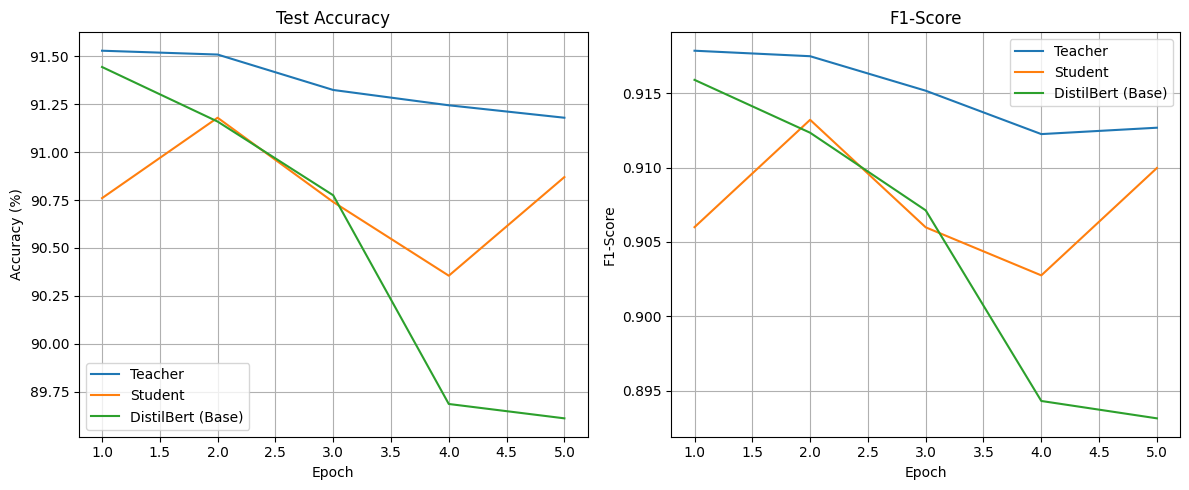

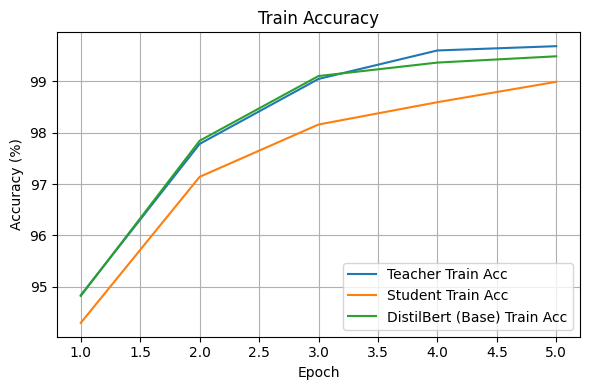

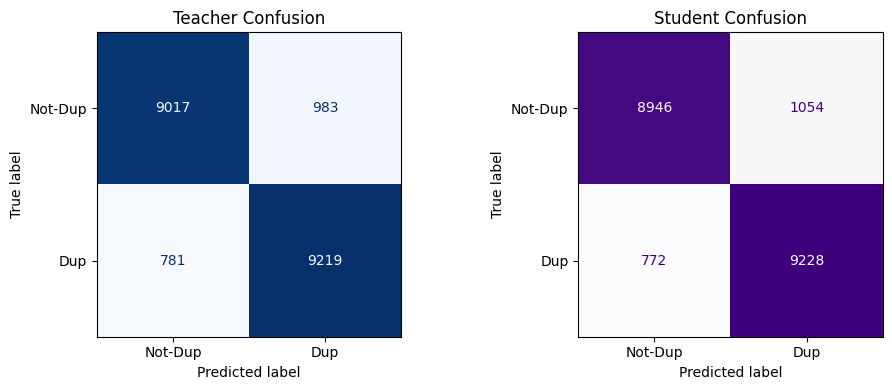

In [89]:
# Combined accuracy / F1 plots
epochs_teacher = range(1, num_epochs      + 1)
epochs_student = range(1, epochs_student  + 1)
epochs_model   = range(1, num_epochs      + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_teacher, test_teacher_accuracy, label='Teacher')
plt.plot(epochs_student, test_student_accuracy, label='Student')
plt.plot(epochs_model, test_baseDistill_accuracy, label='DistilBert (Base)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Test Accuracy'); plt.grid(); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_teacher, teacher_f1, label='Teacher')
plt.plot(epochs_student, f1_student,     label='Student')
plt.plot(epochs_model, f1_baseDistill,     label='DistilBert (Base)')
plt.xlabel('Epoch'); plt.ylabel('F1-Score'); plt.title('F1-Score'); plt.grid(); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_teacher, train_teacher_accuracy, label='Teacher Train Acc')
plt.plot(epochs_student, train_student_accuracy, label='Student Train Acc')
plt.plot(epochs_model, train_baseDistill_accuracy, label='DistilBert (Base) Train Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Train Accuracy')
plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

# Confusion matrices
fig_cm, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm_teacher,  display_labels=['Not-Dup','Dup']).plot(ax=ax1, cmap='Blues',  colorbar=False)
ax1.set_title('Teacher Confusion')
ConfusionMatrixDisplay(cm_student,  display_labels=['Not-Dup','Dup']).plot(ax=ax2, cmap='Purples', colorbar=False)
ax2.set_title('Student Confusion')
plt.tight_layout(); plt.show()

In [90]:
# Print Scores
print(f"Final Teacher Train Accuracy : {train_teacher_accuracy[-1]:.2f}%")
print(f"Final Student Train Accuracy : {train_student_accuracy [-1]:.2f}%")
print(f"Final DistilBert Train Accuracy : {train_baseDistill_accuracy[-1]:.2f}%")
print(f"Final Teacher Test Accuracy : {test_teacher_accuracy[-1]:.2f}%")
print(f"Final Student Test Accuracy : {test_student_accuracy[-1]:.2f}%")
print(f"Final DistilBert Test Accuracy : {test_baseDistill_accuracy[-1]:.2f}%")
print(f"Final Teacher F1-score      : {teacher_f1[-1]:.3f}")
print(f"Final Student F1-score      : {f1_student[-1]:.3f}")
print(f"Final DistilBert F1-score   : {f1_baseDistill[-1]:.3f}")



Final Teacher Train Accuracy : 99.69%
Final Student Train Accuracy : 98.99%
Final DistilBert Train Accuracy : 99.49%
Final Teacher Test Accuracy : 91.18%
Final Student Test Accuracy : 90.87%
Final DistilBert Test Accuracy : 89.61%
Final Teacher F1-score      : 0.913
Final Student F1-score      : 0.910
Final DistilBert F1-score   : 0.893
